In [ ]:
!gdown 1zRHT9eSFUNK6o3AHwQmyAeFzXfEzkEts
!unzip vqa_coco_dataset.zip -d /kaggle/working/vqa_coco_dataset

In [ ]:
!pip install transformers

In [3]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from transformers import ViTModel, ViTImageProcessor
from transformers import AutoTokenizer, RobertaModel

In [4]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed = 59
set_seed(seed)

## Train Val Test Split

In [5]:
def load_data(data_path):
    data = []
    with open(data_path, "r") as f:
        lines = f.readlines()
        for line in lines:
            temp = line.split("\t")
            qa = temp[1].split("?")

            # Extract the answer depending on the length of the split qa list
            answer = qa[2].strip() if len(qa) == 3 else qa[1].strip()

            # Clean the image path by removing the last two characters '#0'
            image_path = temp[0][:-2]

            data.append({
                "image_path": image_path,
                "question": qa[0] + "?",
                "answer": answer
            })
    return data

In [6]:
train_path = "/kaggle/working/vqa_coco_dataset/vaq2.0.TrainImages.txt"
val_path = "/kaggle/working/vqa_coco_dataset/vaq2.0.DevImages.txt"
test_path = "/kaggle/working/vqa_coco_dataset/vaq2.0.TestImages.txt"

train_data = load_data(train_path)
val_data = load_data(val_path)
test_data = load_data(test_path)

len(train_data), len(val_data), len(test_data)

(7846, 1952, 2022)

## Dictionary mapping classes

In [7]:
classes = set([sample["answer"] for sample in train_data])
print("Classes: ", classes)

label2idx = {cls_name : idx for idx, cls_name in enumerate(classes)}
idx2label = {idx: cls_name for idx, cls_name in enumerate(classes)}

print(label2idx)
print(idx2label)

Classes:  {'yes', 'no'}
{'yes': 0, 'no': 1}
{0: 'yes', 1: 'no'}


## VQA Dataset and DataLoader Setup

### VQADataset Class Definition

In [8]:
class VQADataset(Dataset):
    def __init__(self, data, label2idx, img_feature_extractor, text_tokenizer, device, transforms=None, img_dir="/kaggle/working/vqa_coco_dataset/val2014-resised"):
        self.data = data
        self.label2idx = label2idx
        self.img_feature_extractor = img_feature_extractor
        self.text_tokenizer = text_tokenizer
        self.device = device
        self.transforms = transforms
        self.img_dir = img_dir

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        # Preprocess the image
        img_path = os.path.join(self.img_dir, self.data[index]["image_path"])
        img = Image.open(img_path).convert("RGB")
        
        if self.transforms:
            img = self.transforms(img)

        if self.img_feature_extractor:
            img = self.img_feature_extractor(images=img, return_tensors="pt") # Extract features
            img = {k: v.to(self.device).squeeze(0) for k, v in img.items()} # Remove batch dimension

        # Tokenize the question
        question = self.data[index]["question"]
        if self.text_tokenizer:
            question = self.text_tokenizer(
                question,
                padding="max_length", # Pad to max length for uniformity
                max_length=20,
                truncation=True, # Truncate or pad to a max length of 20 tokens
                return_tensors="pt" # Return tensors suitable for PyTorch
            )
            question = {k: v.to(self.device).squeeze(0) for k, v in question.items()}
        
        # Convert the answer label to an index
        label = self.data[index]["answer"]
        label = self.label2idx[label]
        label = torch.tensor(label, dtype=torch.long).to(self.device)

        return {"image": img, "question": question, "label": label}

### Data Transformations


In [9]:
data_transform = transforms.Compose([
        transforms.Resize(size=(224, 224)),
        transforms.CenterCrop(size=180),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
        transforms.RandomHorizontalFlip(),
        transforms.GaussianBlur(3),
    ])

### Dataset Initialization

In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load the pre-trained image feature extractor for ViT 
# The model processes images by dividing them into 16x16 patches of size 224x224 pixels.
img_feature_extractor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224")

# Load the pre-trained tokenizer for the RoBERTa model.
# This tokenizer will convert questions into tokens that the model can process.
text_tokenizer = AutoTokenizer.from_pretrained("roberta-base")

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [11]:
train_dataset = VQADataset(
    train_data,
    label2idx=label2idx,
    img_feature_extractor=img_feature_extractor,
    text_tokenizer=text_tokenizer,
    device=device,
    transforms=data_transform
)

val_dataset = VQADataset(
    val_data,
    label2idx=label2idx,
    img_feature_extractor=img_feature_extractor,
    text_tokenizer=text_tokenizer,
    device=device,
)

test_dataset = VQADataset(
    test_data,
    label2idx=label2idx,
    img_feature_extractor=img_feature_extractor,
    text_tokenizer=text_tokenizer,
    device=device,
)

len(train_dataset), len(val_dataset), len(test_dataset)

(7846, 1952, 2022)

### DataLoader Setup

In [12]:
train_batch_size = 256
test_batch_size = 32

train_loader = DataLoader(
    train_dataset,
    batch_size=train_batch_size,
    shuffle=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=test_batch_size,
    shuffle=False
)

test_loader = DataLoader(
    test_dataset,
    batch_size=test_batch_size,
    shuffle=False
)

len(train_loader), len(val_loader), len(test_loader)

(31, 61, 64)

## Build Model

In [13]:
class VisualEncoder(nn.Module):
    """Encodes images using a pre-trained ViT model."""
    def __init__(self):
        super(VisualEncoder, self).__init__()
        self.model = ViTModel.from_pretrained("google/vit-base-patch16-224")

    def forward(self, inputs):
        outputs = self.model(**inputs)
        return outputs.pooler_output


class TextEncoder(nn.Module):
    """Encodes text (questions) using a pre-trained RoBERTa model."""
    def __init__(self):
        super(TextEncoder, self).__init__()
        self.model = RobertaModel.from_pretrained("roberta-base")

    def forward(self, inputs):
        outputs = self.model(**inputs)
        return outputs.pooler_output


class Classifier(nn.Module):
    """Classifies concatenated image and text features using a simple feed-forward network."""
    def __init__(self, hidden_size=512, dropout_prob=0.2, n_classes=2):
        super(Classifier, self).__init__()
        self.fc1 = nn.Linear(768 * 2, hidden_size)
        self.dropout = nn.Dropout(dropout_prob)
        self.gelu = nn.GELU()
        self.fc2 = nn.Linear(hidden_size, n_classes)

    def forward(self, x):
        x = self.fc1(x)
        x = self.gelu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [14]:
class VQAModel(nn.Module):
    """Combines image and text encoders with a classifier to answer questions based on images."""
    def __init__(self, visual_encoder, text_encoder, classifier):
        super(VQAModel, self).__init__()
        self.visual_encoder = visual_encoder
        self.text_encoder = text_encoder
        self.classifier = classifier
        
    def forward(self, image, answer):
        image_out = self.visual_encoder(image) # Encode image
        text_out = self.text_encoder(answer) # Encode question

        x = torch.cat((image_out, text_out), dim=1) # Concatenate image and text features
        x = self.classifier(x) # Classify using concatenated features

        return x

    def freeze(self, visual=True, textual=True, classifier=False):
        """Freezes (disables gradient computation) for specified model parts"""
        if visual:
            for n, p in self.visual_encoder.named_parameters():
                p.requires_grad = False # Freeze visual encoder
        if textual:
            for n, p in self.text_encoder.named_parameters():
                p.requires_grad = False # Freeze text encoder
        if classifier:
            for n, p in self.classifier.named_parameters():
                p.requires_grad = False # Freeze classifier

In [15]:
n_classes = len(classes)
hidden_size = 256
drop_prob = 0.2

text_encoder = TextEncoder().to(device)
visual_encoder = VisualEncoder().to(device)
classifier = Classifier(hidden_size, drop_prob, n_classes).to(device)

model = VQAModel(
    visual_encoder=visual_encoder,
    text_encoder=text_encoder,
    classifier=classifier
).to(device)
model.freeze()

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Train and Evaluate funtion

In [16]:
def evaluate(moel, dataloader, criterion, device):
    correct, total = 0, 0
    losses = []

    model.eval()
    with torch.no_grad():
        for inputs in dataloader:
            images, questions, labels = inputs["image"], inputs["question"], inputs["label"]

            outputs = model(images, questions)
            loss = criterion(outputs, labels)
            losses.append(loss.item())

            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    loss = np.mean(losses)
    acc = correct / total

    return loss, acc

In [17]:
def fit(model, train_loader, val_loader, criterion, optimizer, scheduler, device, epochs):
    train_losses, train_accs = [], []
    val_losses, val_accs = [], []

    for epoch in range(epochs):
        total, correct = 0, 0
        batch_train_losses = []

        model.train()
        for inputs in train_loader:
            images, questions, labels = inputs["image"], inputs["question"], inputs["label"]

            optimizer.zero_grad()
            outputs = model(images, questions)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            batch_train_losses.append(loss.item())

            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = np.mean(batch_train_losses)
        train_acc = correct / total
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        val_loss, val_acc = evaluate(model, val_loader, criterion, device)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        print(f"Epoch: {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

        scheduler.step()
    return train_losses, train_accs, val_losses, val_accs

In [18]:
lr = 1e-3
epochs = 50
scheduler_step_size = epochs * 0.8
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=scheduler_step_size, gamma=0.1)

train_losses, train_accs, val_losses, val_accs = fit(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    scheduler,
    device,
    epochs
)

Epoch: 1/50 | Train Loss: 0.6966 | Train Acc: 0.5191 | Val Loss: 0.6860 | Val Acc: 0.5564
Epoch: 2/50 | Train Loss: 0.6817 | Train Acc: 0.5602 | Val Loss: 0.6801 | Val Acc: 0.5651
Epoch: 3/50 | Train Loss: 0.6739 | Train Acc: 0.5744 | Val Loss: 0.6814 | Val Acc: 0.5717
Epoch: 4/50 | Train Loss: 0.6702 | Train Acc: 0.5840 | Val Loss: 0.6813 | Val Acc: 0.5656
Epoch: 5/50 | Train Loss: 0.6601 | Train Acc: 0.6025 | Val Loss: 0.6801 | Val Acc: 0.5681
Epoch: 6/50 | Train Loss: 0.6523 | Train Acc: 0.6190 | Val Loss: 0.6818 | Val Acc: 0.5717
Epoch: 7/50 | Train Loss: 0.6363 | Train Acc: 0.6337 | Val Loss: 0.6852 | Val Acc: 0.5743
Epoch: 8/50 | Train Loss: 0.6200 | Train Acc: 0.6507 | Val Loss: 0.6735 | Val Acc: 0.5978
Epoch: 9/50 | Train Loss: 0.5961 | Train Acc: 0.6774 | Val Loss: 0.6751 | Val Acc: 0.6112
Epoch: 10/50 | Train Loss: 0.5776 | Train Acc: 0.6931 | Val Loss: 0.6866 | Val Acc: 0.5994
Epoch: 11/50 | Train Loss: 0.5533 | Train Acc: 0.7201 | Val Loss: 0.6713 | Val Acc: 0.6230
Epoch: 1

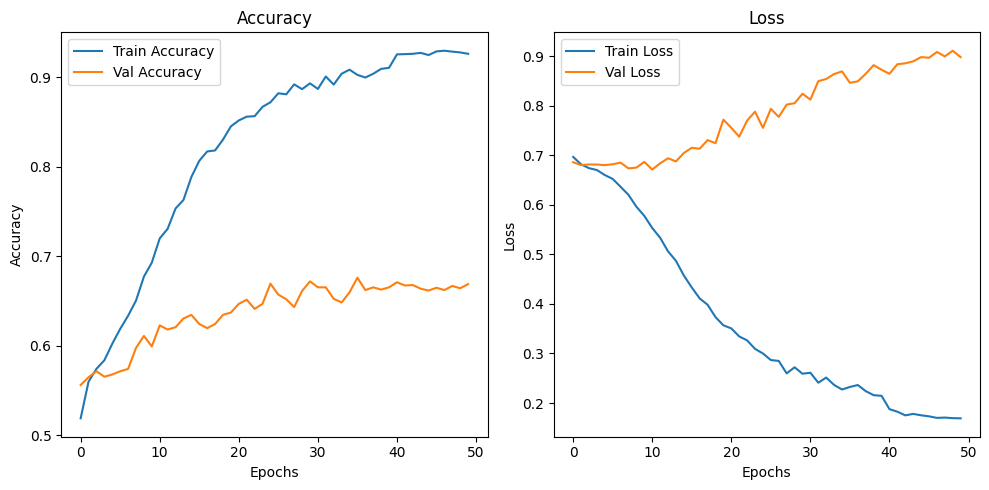

In [19]:
# Plot accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend()

# Show plots
plt.tight_layout()
plt.show()

In [20]:
val_loss, val_acc = evaluate(model, val_loader, criterion, device)
test_loss, test_acc = evaluate(model, test_loader, criterion, device)

print("Evaluation on val/test dataset")
print("Val accuracy: ", val_acc)
print("Test accuracy: ", test_acc)

Evaluation on val/test dataset
Val accuracy:  0.6690573770491803
Test accuracy:  0.6582591493570722


In [21]:
idx = 10
img_name = test_data[idx]["image_path"]
img_path =  os.path.join("/kaggle/working/vqa_coco_dataset/val2014-resised", img_name)
question = test_data[idx]["question"]
answer = test_data[idx]["answer"]

img_path, question, answer

('/kaggle/working/vqa_coco_dataset/val2014-resised/COCO_val2014_000000131539.jpg',
 'Are there any trees visible ?',
 'no')

In [24]:
# Preprocess the image
img = Image.open(img_path).convert("RGB")
img_processed = img_feature_extractor(images=img, return_tensors="pt").to(device)

# # Tokenize the question
question_processed = text_tokenizer(
    question,
    padding="max_length",
    max_length=20,
    truncation=True,
    return_tensors="pt"
).to(device)

model.eval()
with torch.no_grad():
    output = model(img_processed, question_processed)
    pred = torch.argmax(output, dim=1).item() # Get the predicted class label

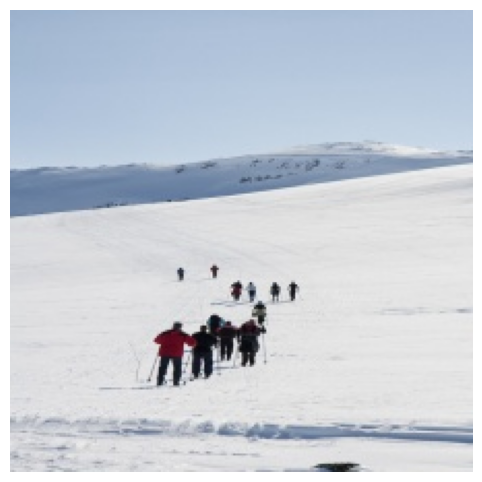

Question: Are there any trees visible ?
Groundtruth: no
Predicted: no


In [29]:
plt.figure(figsize=(12, 6)) 
plt.imshow(img)
plt.axis("off")
plt.show()

print(f"Question: {question}")
print(f"Groundtruth: {answer}")
print(f"Predicted: {idx2label[pred]}")